In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [33]:
d=pd.read_excel('附件1语音业务用户满意度数据.xlsx')

(5433, 55)

- 处理缺失

In [35]:
# 按附件五说明处理缺失
d1=d.drop(labels=['重定向次数','重定向驻留时长','其他，请注明','用户描述','其他，请注明.1','用户描述.1','终端品牌类型','用户id'],axis=1)
d1.drop(d1[d1.是否5G网络客户.isnull()].index,axis=0,inplace=True)
d1.外省流量占比.fillna(np.mean(d1.外省流量占比),inplace=True)
d1.是否关怀用户.fillna('否',inplace=True)
d1.是否去过营业厅.fillna('否',inplace=True)

In [36]:
# 提取定量变量所在列名，便于后续处理
numcols=d1.describe().columns.values[-15:]
numcols

array(['ARPU（家庭宽带）', '套外流量（MB）', '套外流量费（元）', '外省语音占比', '语音通话-时长（分钟）',
       '省际漫游-时长（分钟）', '当月ARPU', '当月MOU', '前3月ARPU', '前3月MOU', '外省流量占比',
       'GPRS总流量（KB）', 'GPRS-国内漫游-流量（KB）', '当月欠费金额', '前第3个月欠费金额'],
      dtype=object)

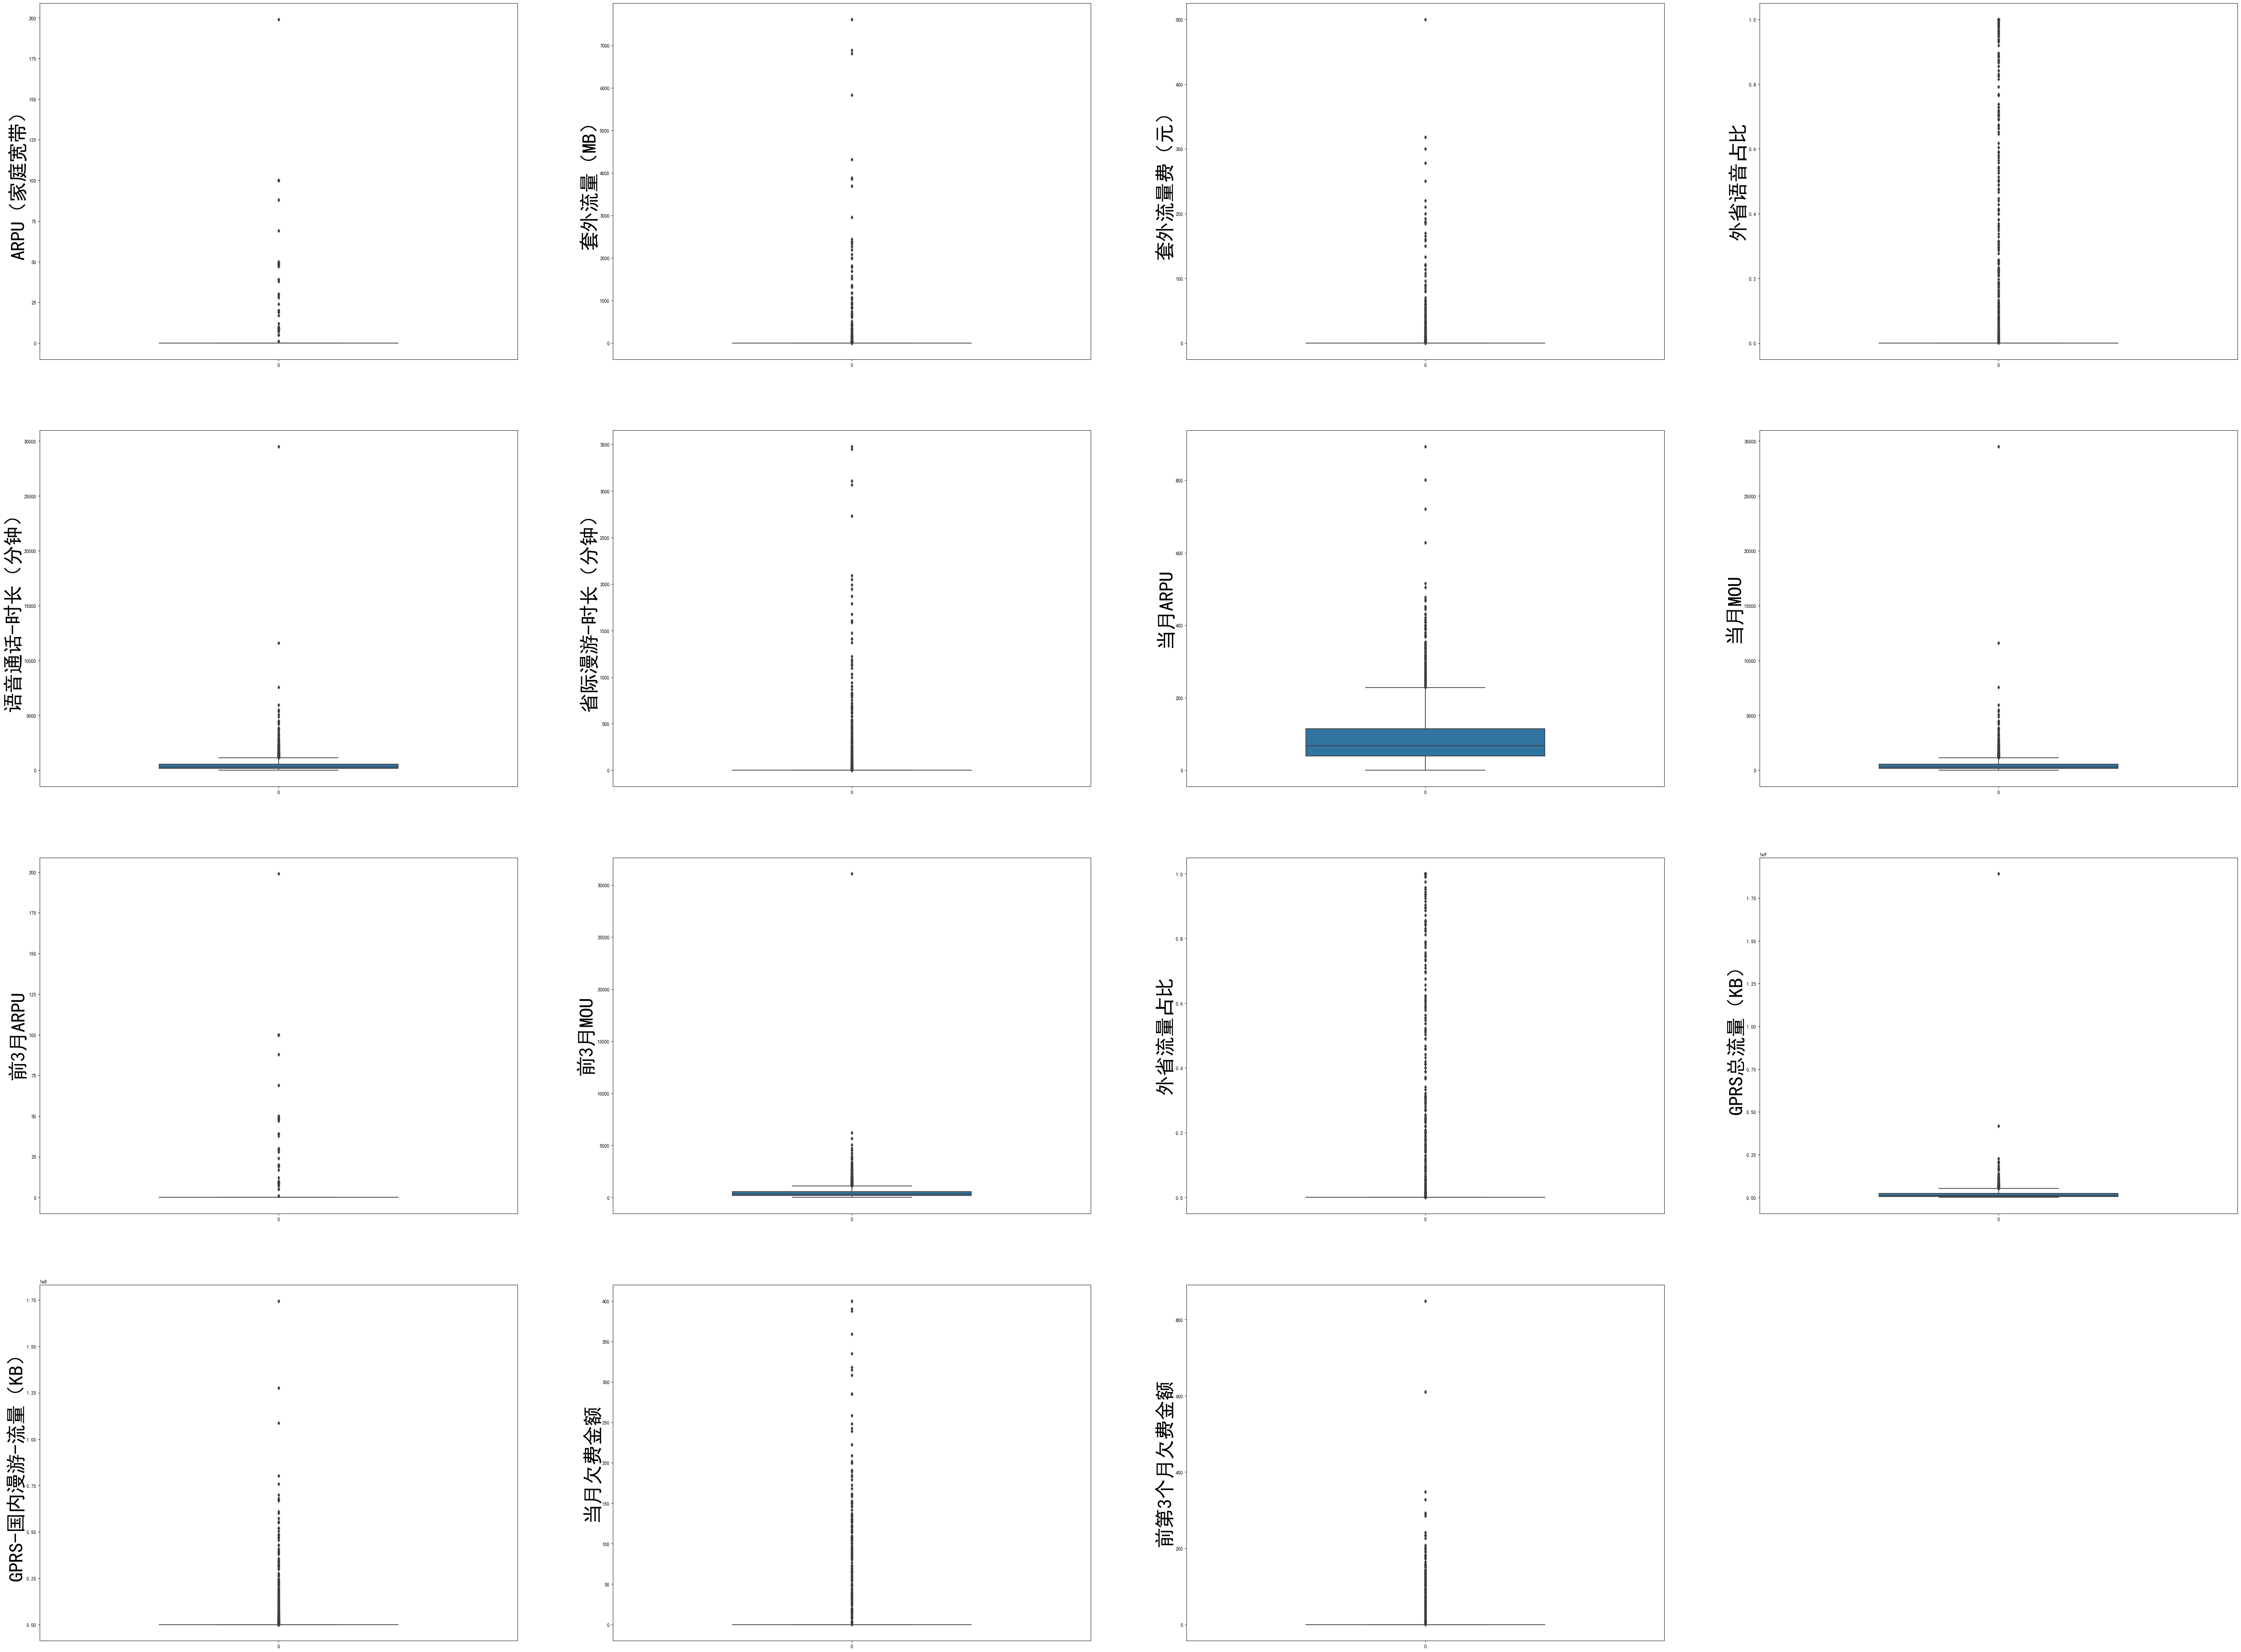

In [37]:
# 画出定量变量箱线图
fig=plt.figure(figsize=(80,60))
for i in range(len(numcols)):
    plt.subplot(4,4,i+1)
    sns.boxplot(d1[numcols[i]],orient='v',width=0.5)
    plt.ylabel(numcols[i],fontsize=40)
plt.show()

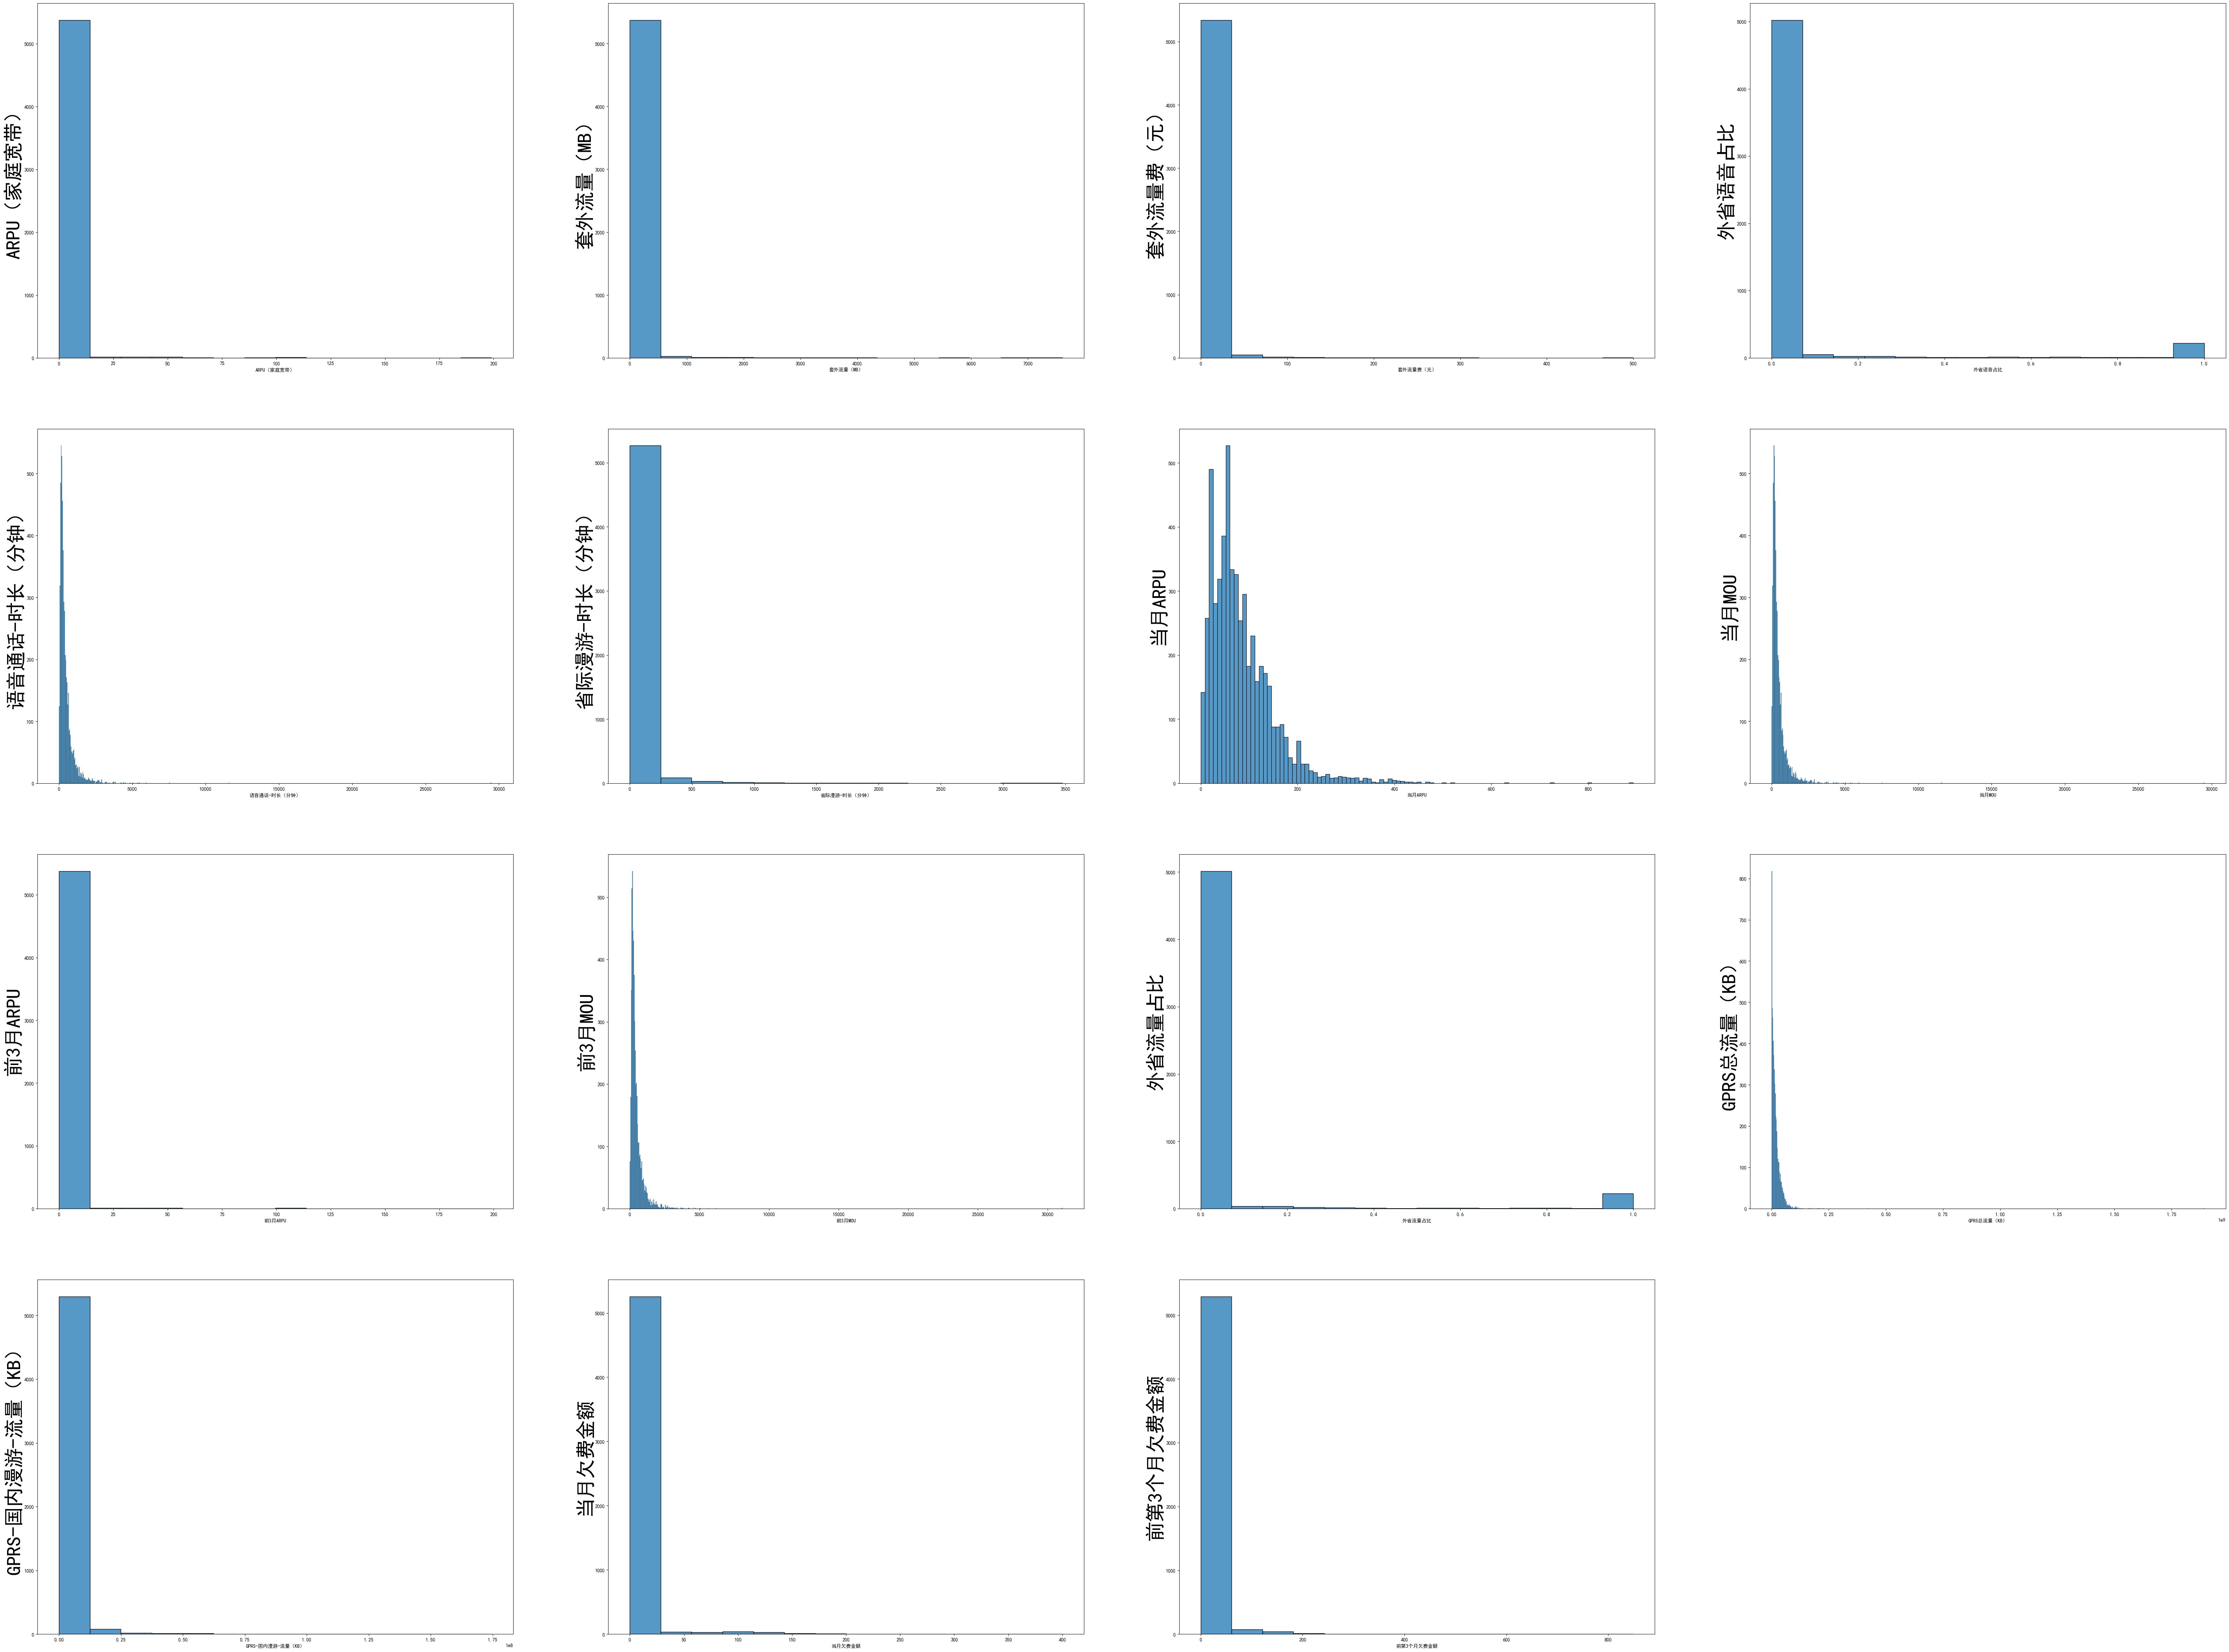

In [38]:
# 画出定量变量直方图
fig=plt.figure(figsize=(80,60))
for i in range(len(numcols)):
    plt.subplot(4,4,i+1)
    sns.histplot(d1[numcols[i]])
    plt.ylabel(numcols[i],fontsize=40)
plt.show()

- 15个数值变量中大多数为0，存在异常值且差异极大，但是通话时长较长或者上网较多的用户，更能够从中发现问题，考虑采用截尾方法处理，将大于$\mu+3\sigma$的数据标记为截尾,替换相应数值。

In [39]:
# 修改异常值 
for i in numcols:
    mean_col=d1[i].mean()
    std_col=d1[i].std()
    d1.loc[d1[d1[i]>mean_col+3*std_col].index,i]=mean_col+3*std_col

ARPU（家庭宽带） change over!
套外流量（MB） change over!
套外流量费（元） change over!
外省语音占比 change over!
语音通话-时长（分钟） change over!
省际漫游-时长（分钟） change over!
当月ARPU change over!
当月MOU change over!
前3月ARPU change over!
前3月MOU change over!
外省流量占比 change over!
GPRS总流量（KB） change over!
GPRS-国内漫游-流量（KB） change over!
当月欠费金额 change over!
前第3个月欠费金额 change over!


In [40]:
# 数值变量标准化
for i in numcols:
    d1[i] = StandardScaler().fit_transform(d1[i].values.reshape(-1,1))

ARPU（家庭宽带） change over!
套外流量（MB） change over!
套外流量费（元） change over!
外省语音占比 change over!
语音通话-时长（分钟） change over!
省际漫游-时长（分钟） change over!
当月ARPU change over!
当月MOU change over!
前3月ARPU change over!
前3月MOU change over!
外省流量占比 change over!
GPRS总流量（KB） change over!
GPRS-国内漫游-流量（KB） change over!
当月欠费金额 change over!
前第3个月欠费金额 change over!
All over!


- 变量重编码

In [41]:
d2=d1.copy()
# 重编码‘是否遇到网络问题’
d2.loc[d2[d2.是否遇到过网络问题==1].index,'是否遇到过网络问题']='是'
d2.loc[d2[d2.是否遇到过网络问题==2].index,'是否遇到过网络问题']='否'
d2.loc[d2[d2['语音方式']=='VoLTE'].index, '语音方式']='VOLTE'

In [42]:
a = ['居民小区', '办公室', '高校', '商业街', '地铁', '农村', '高铁',
'手机没有信号', '有信号无法拨通', '通话过程中突然中断','通话中有杂音、听不清、断断续续', '串线', '通话过程中一方听不见',]
def reindex(x):
       if x == -1:
              x=0
       else:
              x=1
       return x

for i in a:
       d2[i] = d2[i].apply(reindex)

In [43]:
# 将终端品牌分为苹果，华为，小米和其他
def reindex(x):
    name=['苹果','华为','小米科技']
    if x not in name:
        x='其他'
    return x

d2['终端品牌']=d2['终端品牌'].apply(reindex)

In [44]:
# d2.groupby('终端品牌')['终端品牌'].count().plot.bar()


In [45]:
# 查阅北京移动客户分级相关资料，客户星级重分类为（未评级准星一星二星）/（三星）/（银卡）/(金卡，白金卡，钻石卡)
def reindex(x):
    c1=['未评级','准星','一星','二星']
    c2=['三星']
    c3=['银卡']
    c4=['金卡','白金卡','钻石卡']
    if x in c1:
        x=1
    elif x in c2:
        x=2
    elif x in c3:
        x=3
    elif x in c4:
        x=4
    else:
        x
    return x

d2['客户星级标识']=d2['客户星级标识'].apply(reindex)

In [46]:
# d2.groupby('客户星级标识')['客户星级标识'].count().plot.bar()

In [47]:
d2.groupby(['是否5G网络客户','是否4G网络客户（本地剔除物联网）'])['4\\5G用户'].count()
# 可以看出，'4\\5G用户''是否4G网络客户（本地剔除物联网）'是否5G网络客户'三个变量可以用（2g/4g/5g）指标区分,故删除多余变量
d2=d2.drop(['是否4G网络客户（本地剔除物联网）','是否5G网络客户'],axis=1)

In [48]:
d2.groupby('语音通话整体满意度')['语音通话整体满意度'].count()

语音通话整体满意度
1      209
2       42
3       71
4       54
5      172
6      182
7      213
8      567
9      763
10    3155
Name: 语音通话整体满意度, dtype: int64

In [49]:
# d2.to_csv('语音_47变量_标准化_未独热.csv', encoding='utf-8', header=1, index=0)

In [50]:
# 生成排除线性相关变量后的数据集d3
d3=d2.drop(labels=['前3月MOU','语音通话-时长（分钟）',
'外省流量占比','外省语音占比','省际漫游-时长（分钟）',
'前第3个月欠费金额',
'套外流量费（元）',
'前3月ARPU',
'家宽投诉','资费投诉',],axis=1)

In [51]:
# d2=pd.get_dummies(d2)
# d3.to_csv('语音_36变量_标准化_未独热.csv', encoding='utf-8', header=1, index=0)

In [52]:
d3.columns.values

array(['语音通话整体满意度', '网络覆盖与信号强度', '语音通话清晰度', '语音通话稳定性', '是否遇到过网络问题',
       '居民小区', '办公室', '高校', '商业街', '地铁', '农村', '高铁', '手机没有信号', '有信号无法拨通',
       '通话过程中突然中断', '通话中有杂音、听不清、断断续续', '串线', '通话过程中一方听不见', '脱网次数',
       'mos质差次数', '未接通掉话次数', '4\\5G用户', '语音方式', '是否关怀用户', '是否去过营业厅',
       'ARPU（家庭宽带）', '套外流量（MB）', '终端品牌', '当月ARPU', '当月MOU', 'GPRS总流量（KB）',
       'GPRS-国内漫游-流量（KB）', '是否实名登记用户', '客户星级标识', '当月欠费金额'], dtype=object)

In [53]:
# d3.to_csv('语音_未独热_标准化_Q1答案.csv',header=1,index=0,encoding='utf-8')

In [54]:
# 独热编码
d4 = pd.get_dummies(d3)

In [56]:
# d4.to_csv('语音_已独热_标准化_Q1答案.csv',header=1,index=0,encoding='utf-8')

In [132]:
d4.groupby('语音通话整体满意度')['语音通话整体满意度'].count()

语音通话整体满意度
1      209
2       42
3       71
4       54
5      172
6      182
7      213
8      567
9      763
10    3155
Name: 语音通话整体满意度, dtype: int64

- 数据分析

In [57]:
# TomekLink+随机森林
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [58]:
# 定义数据分析所需函数
def x_y_split(data):
    """切分数据框,x在前y在后,按顺序返回x,y1,y2,y3,y4

    Args:
        data (dataframe): X-Y
    """
    x = data.iloc[:, 4:]
    y1 = data.iloc[:, 0]
    y2 = data.iloc[:, 1]
    y3 = data.iloc[:, 2]
    y4 = data.iloc[:, 3]
    return x, y1, y2, y3, y4

def Tomelink(x,y,r_state):
    """from imblearn.combine import SMOTETomek

    Args:
        x (dataframe): design_matrix
        y (dataframe): response_variable
        r_state (int): random_state
    """
    smote_tomek = SMOTETomek(random_state=r_state)
    x_resampled, y_resampled = smote_tomek.fit_resample(x,y)
    return x_resampled, y_resampled



In [140]:
# 手写抽样试一试
import random

def resample(data, num):
    ind = list(data[data['语音通话整体满意度']==num].index)
    n = len(ind)-200
    sam = random.sample(ind,k=n)
    data = data.drop(sam,axis=0)
    return data


d4_test = d4.sample(n=1000, replace=False)
d4_train = d4.drop(d4_test.index)

for i in [8,9,10]:
    d4_train = resample(d4_train, i)

x, y0, y1, y2, y3 = x_y_split(d4_train)
t_x, t_y0,t_y1,t_y2,t_y3 = x_y_split(d4_test)

for n in range(4):
        rfc = RandomForestClassifier().fit(x, eval(f'y{n}'))
        score = rfc.score(t_x, eval(f't_y{n}'))
        print(f'resample{n}:', score)

resample0: 0.386
resample1: 0.379
resample2: 0.422
resample3: 0.421


In [141]:
d4_train.groupby('语音通话整体满意度')['语音通话整体满意度'].count()

语音通话整体满意度
1     169
2      36
3      59
4      42
5     140
6     150
7     182
8     200
9     200
10    200
Name: 语音通话整体满意度, dtype: int64

In [ ]:
x, y0, y1, y2, y3 = x_y_split(d4)
for y in [y0, y1, y2, y3]:
    for i in range(3):
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, shuffle=1)
        rfc = RandomForestClassifier(class_weight='balanced').fit(x_train,y_train)
        print(rfc.score(x_test, y_test))

In [78]:
# d4中抽取1000样本作为测试集，使用重采样训练过后的分类器进行分类，判断准确率，验证采样器性能,由于样本分布不均，采用无放回抽样，
# 采样5次，查看误差
for loop in range(5):
    d4_test = d4.sample(n=1000, replace=False)
    d4_train = d4.drop(d4_test.index)
    x, y0, y1, y2, y3 = x_y_split(d4_train)
    t_x, t_y0,t_y1,t_y2,t_y3 = x_y_split(d4_test)

    x_resampled = {}
    y_resampled = {}
    for i in range(4):
        x_resampled[i] = Tomelink(x, eval(f"y{i}"), 123)[0]
        y_resampled[i] = Tomelink(x, eval(f"y{i}"), 123)[1]

    print(f'第{loop}次测试：')
    for n in range(4):
        rfc = RandomForestClassifier().fit(x_resampled[n],y_resampled[n])
        score = rfc.score(t_x, eval(f't_y{n}'))
        print(f'resample{n}:', score)


第0次测试：
resample1: 0.498
resample2: 0.42
resample3: 0.458
resample4: 0.439
第1次测试：
resample1: 0.489
resample2: 0.427
resample3: 0.466
resample4: 0.446
第2次测试：
resample1: 0.491
resample2: 0.412
resample3: 0.454
resample4: 0.429
第3次测试：
resample1: 0.499
resample2: 0.444
resample3: 0.481
resample4: 0.468
第4次测试：
resample1: 0.489
resample2: 0.435
resample3: 0.466
resample4: 0.443


In [84]:
# 有放回抽样测试
for loop in range(5):
    d4_test = d4.sample(n=1000, replace=True)
    d4_train = d4.drop(d4_test.index)
    x, y0, y1, y2, y3 = x_y_split(d4_train)
    t_x, t_y0,t_y1,t_y2,t_y3 = x_y_split(d4_test)

    x_resampled = {}
    y_resampled = {}
    for i in range(4):
        x_resampled[i] = Tomelink(x, eval(f"y{i}"), 123)[0]
        y_resampled[i] = Tomelink(x, eval(f"y{i}"), 123)[1]

    print(f'第{loop}次测试：')
    for n in range(4):
        rfc = RandomForestClassifier().fit(x_resampled[n],y_resampled[n])
        score = rfc.score(t_x, eval(f't_y{n}'))
        print(f'resample{n}:', score)

第0次测试：
resample1: 0.513
resample2: 0.431
resample3: 0.469
resample4: 0.476
第1次测试：
resample1: 0.484
resample2: 0.417
resample3: 0.473
resample4: 0.43
第2次测试：
resample1: 0.477
resample2: 0.415
resample3: 0.459
resample4: 0.429
第3次测试：
resample1: 0.485
resample2: 0.427
resample3: 0.469
resample4: 0.427
第4次测试：
resample1: 0.499
resample2: 0.433
resample3: 0.472
resample4: 0.453


- Tomeklink是有问题的，效果不如不做过采样
  1. 切分
  2. 操作
  3. 验证

In [114]:
# ADASYN: 关注的是在那些基于K最近邻分类器被错误分类的原始样本附近生成新的少数类样本
from imblearn.over_sampling import ADASYN
x_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_resample(x, y0)
sorted(Counter(y_resampled_adasyn).items())

[(1, 3128),
 (2, 3170),
 (3, 3131),
 (4, 3168),
 (5, 3196),
 (6, 3128),
 (7, 3104),
 (8, 3062),
 (9, 3236),
 (10, 3155)]

In [115]:
for loop in range(3):
    d4_test = d4.sample(n=1000, replace=False)
    d4_train = d4.drop(d4_test.index)
    x, y0, y1, y2, y3 = x_y_split(d4_train)
    t_x, t_y0,t_y1,t_y2,t_y3 = x_y_split(d4_test)

    x_resampled = {}
    y_resampled = {}
    for i in range(4):
        x_resampled[i] = ADASYN().fit_resample(x, eval(f"y{i}"))[0]
        y_resampled[i] = ADASYN().fit_resample(x, eval(f"y{i}"))[1]

    print(f'第{loop}次测试：')
    for n in range(4):
        rfc = RandomForestClassifier().fit(x_resampled[n],y_resampled[n])
        score = rfc.score(t_x, eval(f't_y{n}'))
        print(f'resample{n}:', score)

第0次测试：
resample0: 0.466
resample1: 0.416
resample2: 0.467
resample3: 0.426
第1次测试：
resample0: 0.467
resample1: 0.405
resample2: 0.461
resample3: 0.449
第2次测试：
resample0: 0.494
resample1: 0.433
resample2: 0.479
resample3: 0.453


In [117]:
# RandomUnderSampler函数是一种快速并十分简单的方式来平衡各个类别的数据: 随机选取数据的子集.
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(x, y0)
sorted(Counter(y_resampled).items())

[(1, 32),
 (2, 32),
 (3, 32),
 (4, 32),
 (5, 32),
 (6, 32),
 (7, 32),
 (8, 32),
 (9, 32),
 (10, 32)]

In [120]:
for loop in range(3):
    d4_test = d4.sample(n=1000, replace=False)
    d4_train = d4.drop(d4_test.index)
    x, y0, y1, y2, y3 = x_y_split(d4_train)
    t_x, t_y0,t_y1,t_y2,t_y3 = x_y_split(d4_test)

    x_resampled = {}
    y_resampled = {}
    for i in range(4):
        x_resampled[i] = RandomUnderSampler(random_state=0).fit_resample(x, eval(f"y{i}"))[0]
        y_resampled[i] = RandomUnderSampler(random_state=0).fit_resample(x, eval(f"y{i}"))[1]

    print(f'第{loop}次测试：')
    for n in range(4):
        rfc = RandomForestClassifier().fit(x_resampled[n],y_resampled[n])
        score = rfc.score(t_x, eval(f't_y{n}'))
        print(f'resample{n}:', score)

第0次测试：
resample0: 0.301
resample1: 0.358
resample2: 0.306
resample3: 0.358
第1次测试：
resample0: 0.319
resample1: 0.307
resample2: 0.324
resample3: 0.308
第2次测试：
resample0: 0.292
resample1: 0.333
resample2: 0.333
resample3: 0.369


In [127]:
# 使用RandomOverSampler从少数类的样本中进行随机采样来增加新的样本使各个分类均衡
from imblearn.over_sampling import RandomOverSampler
 
x_resampled, y_resampled = RandomOverSampler(random_state=0).fit_resample(x, y0)
sorted(Counter(y_resampled).items())

[(1, 3155),
 (2, 3155),
 (3, 3155),
 (4, 3155),
 (5, 3155),
 (6, 3155),
 (7, 3155),
 (8, 3155),
 (9, 3155),
 (10, 3155)]

In [128]:
for loop in range(3):
    d4_test = d4.sample(n=1000, replace=False)
    d4_train = d4.drop(d4_test.index)
    x, y0, y1, y2, y3 = x_y_split(d4_train)
    t_x, t_y0,t_y1,t_y2,t_y3 = x_y_split(d4_test)

    x_resampled = {}
    y_resampled = {}
    for i in range(4):
        x_resampled[i] = RandomOverSampler(random_state=0).fit_resample(x, eval(f"y{i}"))[0]
        y_resampled[i] = RandomOverSampler(random_state=0).fit_resample(x, eval(f"y{i}"))[1]

    print(f'第{loop}次测试：')
    for n in range(4):
        rfc = RandomForestClassifier().fit(x_resampled[n],y_resampled[n])
        score = rfc.score(t_x, eval(f't_y{n}'))
        print(f'resample{n}:', score)

第0次测试：
resample0: 0.559
resample1: 0.473
resample2: 0.524
resample3: 0.501
第1次测试：
resample0: 0.536
resample1: 0.464
resample2: 0.502
resample3: 0.479
第2次测试：
resample0: 0.538
resample1: 0.467
resample2: 0.514
resample3: 0.465


In [131]:
# BalancedBaggingClassifier 允许在训练每个基学习器之前对每个子集进行重抽样. 简而言之, 该方法结合了EasyEnsemble采样器与分类器(如BaggingClassifier)的结果.
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
for i in range(4):
    bbc = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced'),
                    replacement=False,
                    random_state=0)
    x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y0, test_size=0.3, shuffle=1)
    bbc.fit(x_train, y_train) 
    print(bbc.score(x_test, y_test))

d:\Soft\Python\lib\site-packages\imblearn\ensemble\_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


0.44996237772761477


d:\Soft\Python\lib\site-packages\imblearn\ensemble\_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


0.41911211437170803


d:\Soft\Python\lib\site-packages\imblearn\ensemble\_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


0.42663656884875845


d:\Soft\Python\lib\site-packages\imblearn\ensemble\_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


0.42663656884875845


In [126]:
x, y0, y1, y2, y3 = x_y_split(d4)
for y in [y0, y1, y2, y3]:
    for i in range(3):
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, shuffle=1)
        rfc = RandomForestClassifier(class_weight='balanced').fit(x_train,y_train)
        print(rfc.score(x_test, y_test))


0.5598526703499079
0.5794966236955187
0.5807243707796194
0.4794352363413137
0.47206875383670965
0.5052179251074279
0.5604665438919583
0.5303867403314917
0.5322283609576427
0.52731737262124
0.516267648864334
0.5095150399017803


In [133]:
x, y0, y1, y2, y3 = x_y_split(d4)
for y in [y0, y1, y2, y3]:
    for i in range(3):
        x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3)
        rfc = RandomForestClassifier().fit(x_train,y_train)
        print(rfc.score(x_test, y_test))


0.5813382443216697
0.5776550030693677
0.5733578882750153
0.48066298342541436
0.5009208103130756
0.49846531614487416
0.5260896255371393
0.534683855125844
0.5383670963781461
0.5113566605279313
0.4972375690607735
0.5119705340699816


In [79]:
# 使用36变量测试
x, y0, y1, y2, y3 = x_y_split(d4)
x_resampled = {}
y_resampled = {}
for i in range(4):
    x_resampled[i] = Tomelink(x, eval(f"y{i}"), 123)[0]
    y_resampled[i] = Tomelink(x, eval(f"y{i}"), 123)[1]
rfc_list_35variable = [] # 这里存储了四个训练好的分类器
for i in range(4):
    a, b = RF(x_resampled[i], y_resampled[i],123)
    rfc_list_35variable.append(a)
    print(b)
# 从结果来看，相同的X 拟合y1,y2,y3,y4准确率差距不大

RandomForest:0.9111276279464855
RandomForest:0.8772235352655803
RandomForest:0.9045689849200991
RandomForest:0.882769378449724


In [83]:
a = rfc_list_35variable[0]# 因为这里是全数据，所以准确度高，
a.score(t_x, t_y1)

0.909

In [ ]:
rfc.score()

In [65]:
a = rfc_list_35variable[0]
a.feature_importances_

0.9999999999999998

Text(0.5, 0, 'Random Forest Feature Importance')

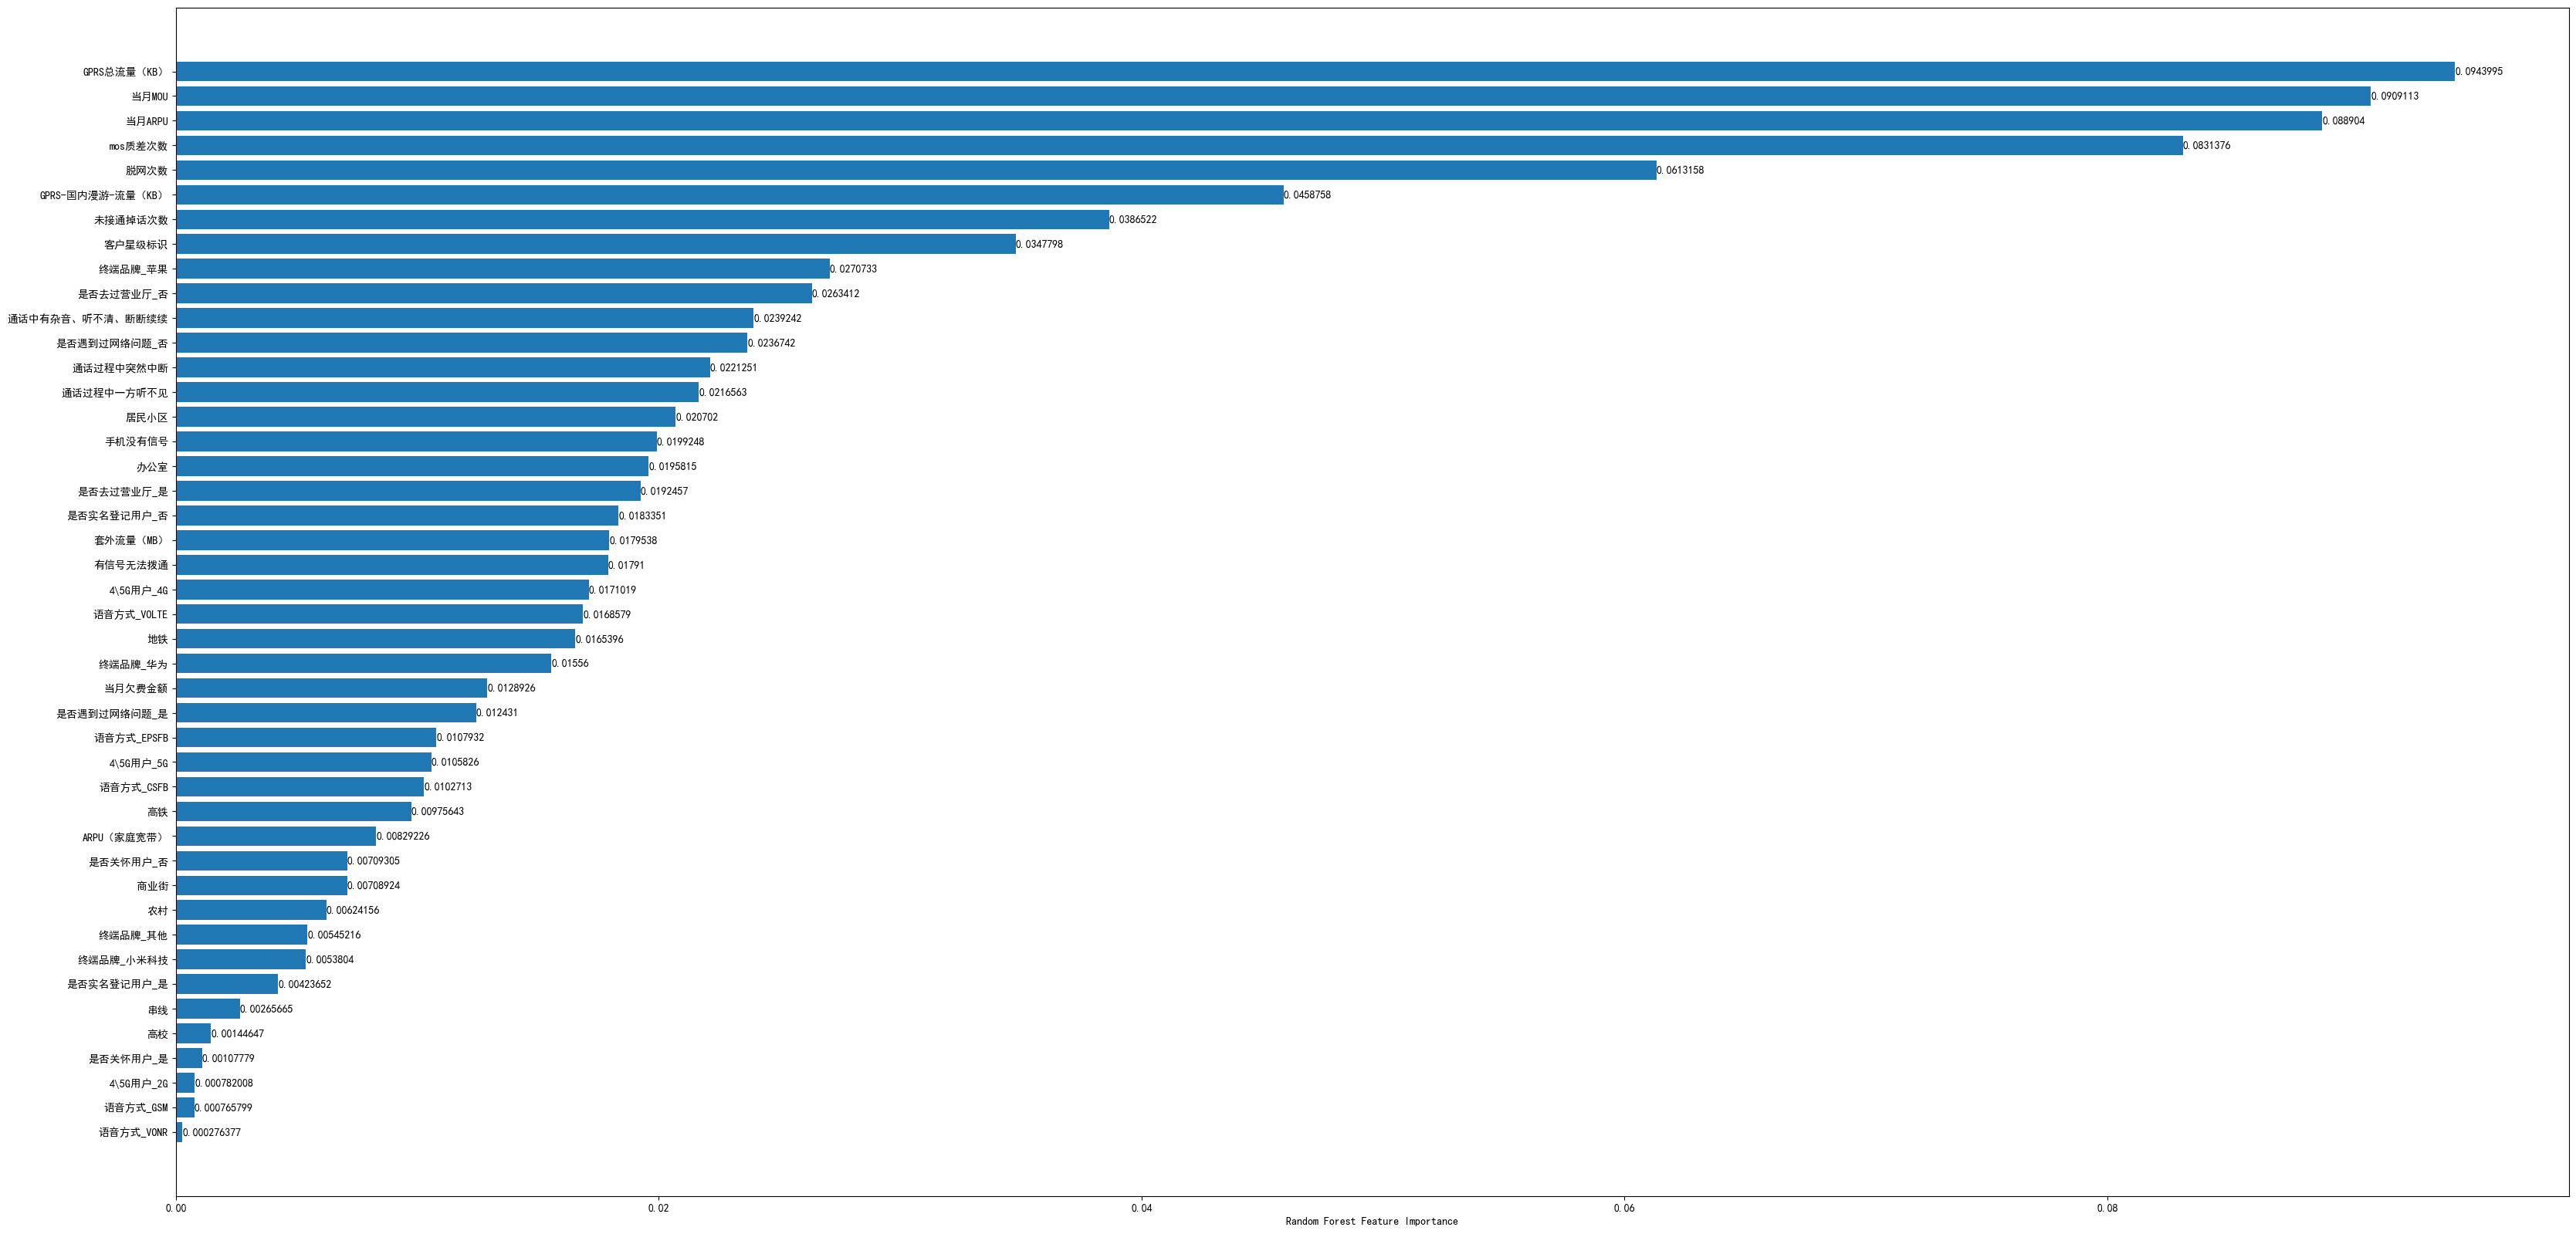

In [63]:
sorted_idx = a.feature_importances_.argsort()
plt.figure(figsize=(40,20))
p = plt.barh(a.feature_names_in_[sorted_idx], a.feature_importances_[sorted_idx])
plt.bar_label(p)
plt.xlabel("Random Forest Feature Importance")


In [83]:
# 测试用分项满意度拟合整体满意度。首先看y1,y2,y3拟合y0的表现
X = pd.concat([y1,y2,y3], axis=1)
resamp = Tomelink(X, y1, r_state=123)
rfc, score = RF(resamp[0], resamp[1], 123)
print(score)
# 分项表现很差，所以确定最终是由特征，直接拟合y1,y2,y3

RandomForest:0.6651875330163761


In [66]:
# 使用47变量数据试一试
data = pd.get_dummies(d2, drop_first=1)
x, y0, y1, y2, y3 = x_y_split(data)
x_resampled = {}
y_resampled = {}
for i in range(4):
    x_resampled[i] = Tomelink(x, eval(f"y{i}"), 123)[0]
    y_resampled[i] = Tomelink(x, eval(f"y{i}"), 123)[1]
rfc_list_47variable = [] # 这里存储了四个训练好的分类器 
for i in range(4):
    a, b = RF(x_resampled[1], y_resampled[1],123)
    rfc_list_47variable.append(a)
    print(b)
# 35版本有改进，所以还可以再剔除

RandomForest:0.9045902682073571
RandomForest:0.9044842573942542
RandomForest:0.9035301600763278
RandomForest:0.901515954627372


In [67]:
#数据量很大时，如使用有放回采样，可以保证66%左右的样本至少取到一次，33%左右取不到，因此可以用训练数据对模型评估
rf_oob=RandomForestClassifier(n_estimators=50,bootstrap=True,oob_score=True,random_state=1).fit(x_resampled[1],y_resampled[1])
print("准确度为：",rf_oob.oob_score_)  

准确度为： 0.9019464410660899


In [68]:
# 测试未Tomelink处理数据
a, b = RF(x, y1,123)
print(b)

RandomForest:0.5623081645181093


In [69]:
# 再用xgb做一下试试看，47变量版本
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [118]:
x, y0, y1, y2, y3 = x_y_split(d4)

In [103]:
# xgb分类变量需要编码至0~9

y0 = y0 - 1

In [119]:
sorted(Counter(y0).items())

[(1, 209),
 (2, 42),
 (3, 71),
 (4, 54),
 (5, 172),
 (6, 182),
 (7, 213),
 (8, 567),
 (9, 763),
 (10, 3155)]

In [111]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y0, test_size=0.3, shuffle=1)
xgb=XGBClassifier()
xgb.fit(x_train,y_train)
#预测
y0_pred=xgb.predict(x_test)

#准确率
accuracy=accuracy_score(y_test,y0_pred)
print('accu：%.2f%%' % (accuracy *100)) # 这是47变量版本结果

accu：55.19%


In [73]:
# 这里试验36变量xgb
# xgb分类变量需要编码至0~9
y_resampled[1]=y_resampled[1]-1
sorted(Counter(y_resampled[1]).items())

[(0, 3142),
 (1, 3153),
 (2, 3153),
 (3, 3154),
 (4, 3147),
 (5, 3150),
 (6, 3149),
 (7, 3135),
 (8, 3108),
 (9, 3101)]

In [74]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_resampled[1], y_resampled[1], test_size=0.3, shuffle=1, random_state=123)
model=XGBClassifier()
model.fit(x_train,y_train)
#预测
y_pred=model.predict(x_test)

#准确率
accuracy=accuracy_score(y_test,y_pred)
print('accu：%.2f%%' % (accuracy *100)) # 这是35变量版本结果,相比47版本同样提升0.01

accu：86.87%


In [103]:
print(accuracy_score(y_test, y_pred))

0.8847139197267293


<Figure size 8000x6000 with 0 Axes>

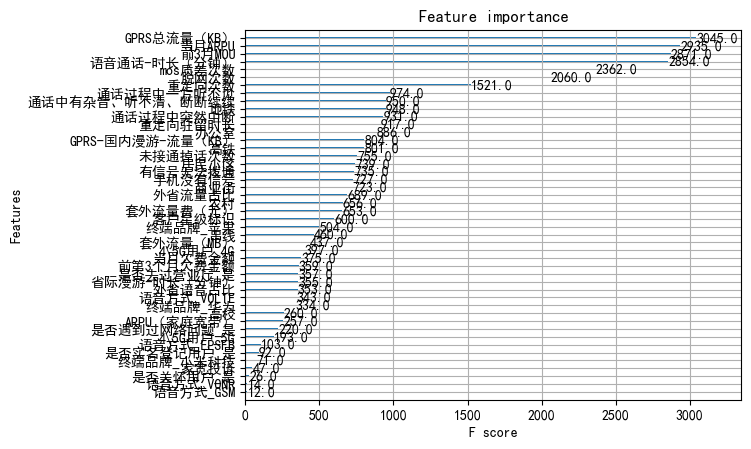

In [102]:
# 特征重要性
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [79]:
sorted(Counter(y_resampled[3]).items())

[(1, 2978),
 (2, 2979),
 (3, 2979),
 (4, 2976),
 (5, 2979),
 (6, 2972),
 (7, 2967),
 (8, 2946),
 (9, 2918),
 (10, 2902)]

In [ ]:
# 先模型评价再参数搜索，

In [ ]:
# K折交叉验证
# from sklearn.model_selection import KFold

# for k,(train_index, test_index) in enumerate(KFold.split(d4)):
#     x_train, x_test, y_train, y_test = x[train_index], x[test_index], y1[train_index], y1[test_index]
#     rfc = RandomForestClassifier().fit(x_train, y_train)
#     score_train = rfc.score()

In [27]:
# 网格搜索 RF 主要影响参数有根据情况确定影响，criterion;单调递增，n_estimators;
# 模型性能，max_leaf_nodes;max_depth;min_samples_split;min_samples_leaf;min_weight_fraction_leaf
from sklearn.model_selection import GridSearchCV
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_resampled[1], y_resampled[1], test_size=0.3,random_state=1)
param = {
    "n_estimators": [25,50,75,100,125],
    "max_depth": [6,8,10,12,14]
}
randomForestclassifier = RandomForestClassifier()
grid_rfc = GridSearchCV(randomForestclassifier, param, cv=3, scoring='accuracy')
grid_rfc.fit(x_train, y_train)
score_test = accuracy_score(y_test, grid_rfc.predict(x_test))
print(score_test)
print(grid_rfc.best_estimator_)


0.8855837671305641
RandomForestClassifier(max_depth=14, n_estimators=125)


In [60]:
# 此处可以画图进一步解释，更加直观
grid_rfc.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [52]:
grid_rfc.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'n_jobs': None,
 'param_grid': {'n_estimators': [25, 50, 75, 100, 125],
  'max_depth': [6, 8, 10, 12, 14]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 0}

In [28]:
rfc = RandomForestClassifier().fit(x_train,y_train)
rfc.score(x_test,y_test)

0.9234038032508233

In [54]:
rfc = RandomForestClassifier(bootstrap=1, oob_score=1).fit(x_train,y_train)
rfc.score(x_test,y_test)

0.9228726229682355

In [57]:
rfc.get_params()

{'bootstrap': 1,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': 1,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [51]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

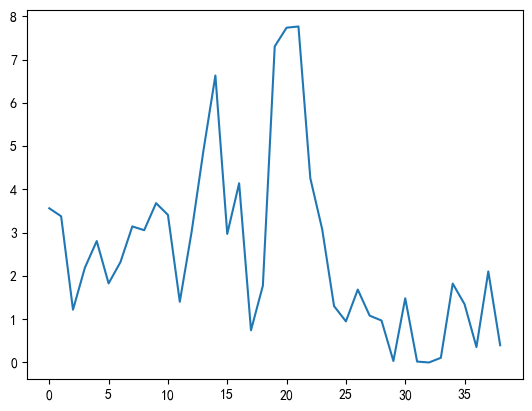

In [43]:
plt.plot(100*rfc.feature_importances_)
plt.show()

In [45]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# 变量选择再次进行，删除

In [ ]:
d4.groupby()